# Sales forecast

1/1 [==============================] - 0s 28ms/step


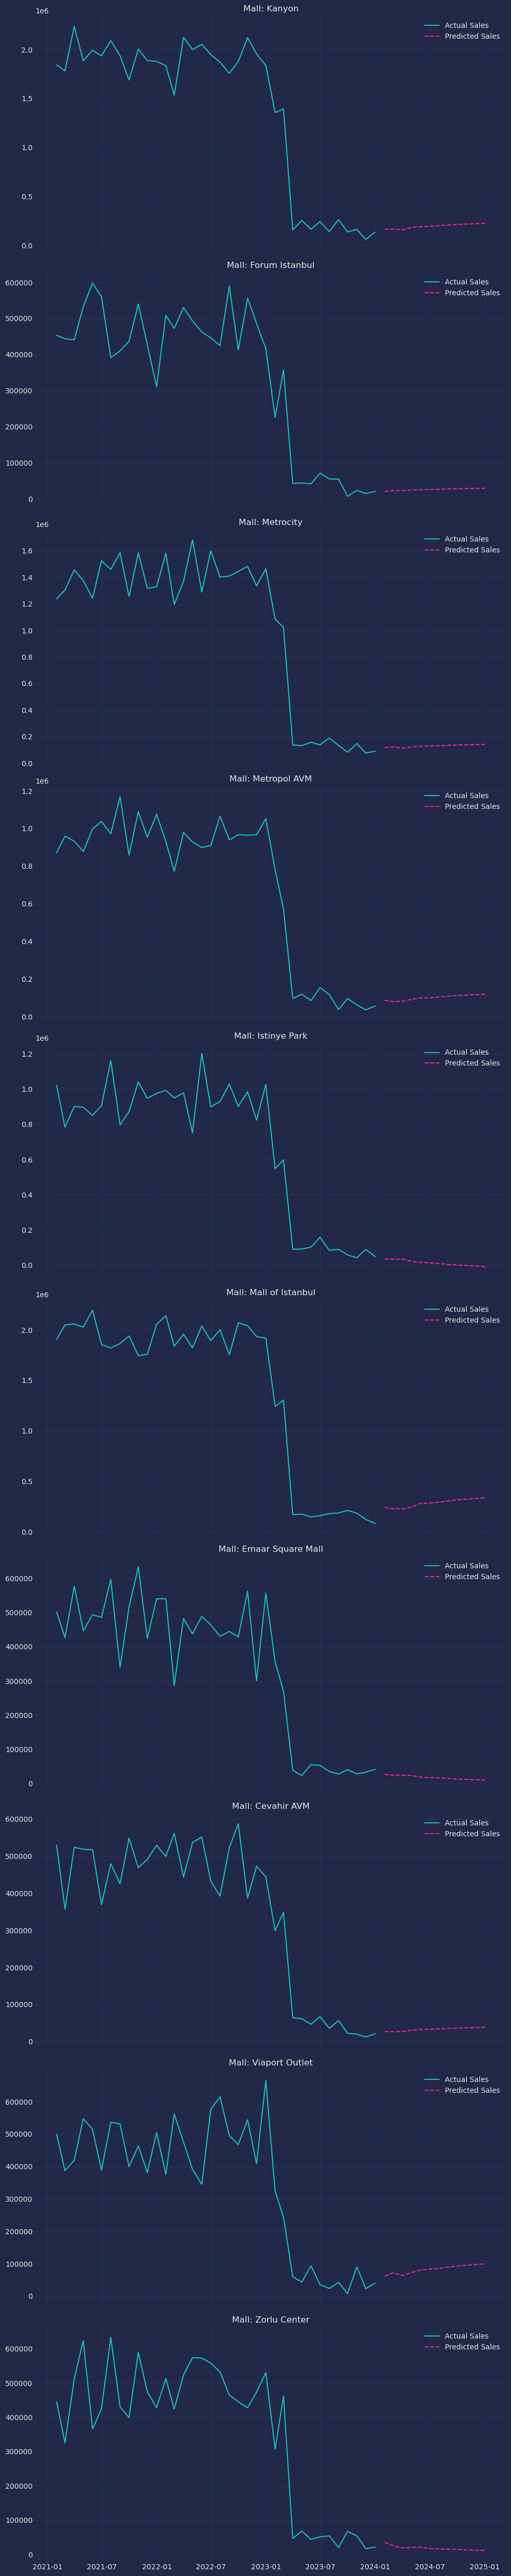

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df with columns 'year', 'month', 'day', 'shopping_mall', 'total_price'
# Convert 'year', 'month', and 'day' to datetime format
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

# Get unique shopping malls
unique_malls = df['shopping_mall'].unique()

# Use Min-Max scaling to normalize the data
scaler = MinMaxScaler()

# Create subplots
fig, axes = plt.subplots(len(unique_malls), 1, figsize=(10, 5 * len(unique_malls)), sharex=True)

for i, mall in enumerate(unique_malls):
    # Choose a shopping mall
    mall_data = df[df['shopping_mall'] == mall][['date', 'total_price']]

    # Aggregate daily data to monthly data
    monthly_data = mall_data.resample('M', on='date').sum()

    # Set the index to 'date' if it's not already set
    if 'date' not in monthly_data.columns:
        monthly_data = monthly_data.reset_index()

    # Set 'date' as the index
    monthly_data.set_index('date', inplace=True)

    # Use Min-Max scaling to normalize the data for LSTM
    scaled_data = scaler.fit_transform(np.array(monthly_data['total_price']).reshape(-1, 1))

    # Function to prepare data for LSTM
    def prepare_data(data, time_steps):
        X, y = [], []
        for i in range(len(data) - time_steps):
            X.append(data[i:(i + time_steps), 0])
            y.append(data[i + time_steps, 0])
        return np.array(X), np.array(y)

    # Define the number of time steps
    time_steps = 4  # You may need to adjust this based on the seasonality of your data
    X, y = prepare_data(scaled_data, time_steps)

    # Reshape the data for LSTM input
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model on the entire dataset
    model.fit(X, y, epochs=50, batch_size=16, verbose=0)

    # Make monthly sales predictions for the next 12 months
    future_steps = 12
    future_dates = pd.date_range(start=monthly_data.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='MS')
    future_inputs = scaled_data[-time_steps:].reshape(1, -1, 1)

    future_predictions = []
    for _ in range(future_steps):
        prediction = model.predict(future_inputs)
        future_predictions.append(prediction[0, 0])
        future_inputs = np.roll(future_inputs, -1)
        future_inputs[-1, -1] = prediction[0, 0]

    # Invert the scaling to get the actual sales values
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    # Plot the results for each mall
    axes[i].plot(monthly_data.index, monthly_data['total_price'], label='Actual Sales')
    axes[i].plot(future_dates, future_predictions, label='Predicted Sales', linestyle='--')
    axes[i].set_title(f'Mall: {mall}')
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()
